In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.cm as cm
import os
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import geopandas as gpd
from analysisFuncs import applyFunc, plot_map, getRegion, regions, ens_list, templates, gcm_yr_list
from dask_jobqueue import PBSCluster
import dask
from dask.distributed import Client
import time
import matplotlib.cm as cm

turbo_r = cm.get_cmap('turbo_r')
mask = xr.open_dataset('conus_gmet_mask2.nc')['mask'].values

In [5]:

var='pcp'

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)
gard_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_HI.nc'%var)
gard_hi_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_AK.nc'%var)
gard_ak_ens = ds.sel(n_ens=ds.gcm=='canesm5').sel(year=slice('1950','2099'))

g = 'cesmlens2'
gcm_data = []
ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_CONUS.nc'%(g,var))

gcm_ens = ds.sel(year=slice('1950','2099'))

/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


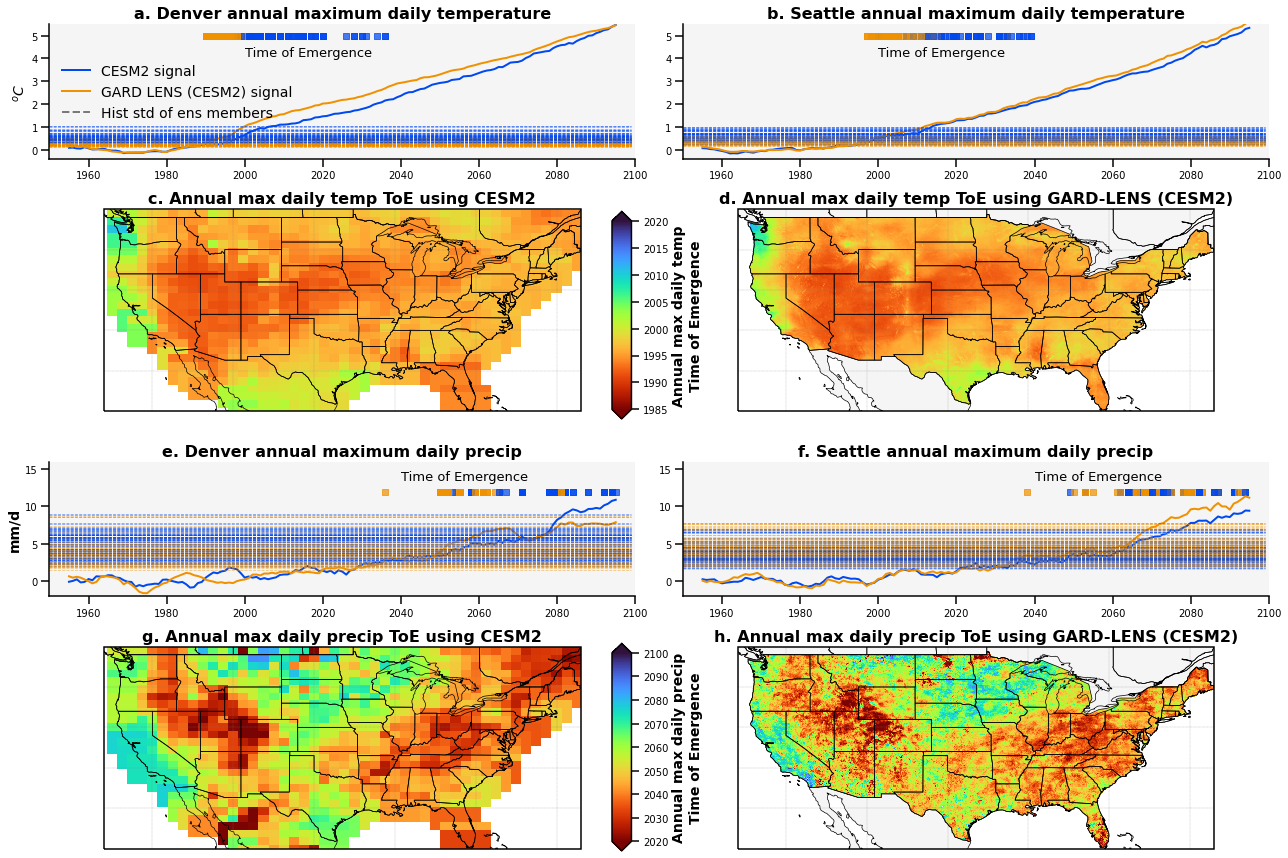

In [55]:

func = 'max'
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,12))

gs = gridspec.GridSpec(4, 2, height_ratios=[2, 3, 2, 3], width_ratios=[1, 1])

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_t_mean_stats_CONUS.nc')
gard_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_t_mean_stats_HI.nc')
gard_hi_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_t_mean_stats_AK.nc')
gard_ak_ens = ds.sel(n_ens=ds.gcm=='canesm5').sel(year=slice('1950','2099'))

g = 'cesmlens2'
gcm_data = []
ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_t_mean_stats_CONUS.nc'%(g))

gcm_ens = ds.sel(year=slice('1950','2099'))

l = ('a.','b.','c.','d.','e.','f.','g.','h.')

i=1
for loc in ('DENV','SEAT'):
    
    ax1 = fig.add_subplot(gs[0,i-1])
    r = regions[loc]
    gcm_seat = gcm_ens.sel(lat=r[0],lon=r[1],method='nearest')[func].rolling(year=10,center=True).mean()
    gcm_signal = gcm_seat.mean('n_ens')-gcm_seat.sel(year=slice('1960','1990')).mean(('year','n_ens'))
    ax1.plot(gcm_seat.year,gcm_signal,c='#0048EF',label='CESM2 signal')
    
    gard_seat = gard_ens.sel(lat=r[0],lon=r[1],method='nearest')[func].rolling(year=10,center=True).mean()
    gard_signal = gard_seat.mean('n_ens')-gard_seat.sel(year=slice('1960','1990')).mean(('year','n_ens'))
    ax1.plot(gard_seat.year,gard_signal,c='#EF9100',label='GARD LENS (CESM2) signal')
    
    for e in gard_seat.n_ens[:]:
        gard_std = gard_seat.sel(n_ens=e).sel(year=slice('1960','1990')).std()
        ax1.plot((gard_seat.year[0],gard_seat.year[-1]),(gard_std,gard_std),c='#EF9100',
                 alpha=0.5,linestyle='dashed',linewidth=0.8)
        ax1.scatter(gard_seat.year.where(gard_signal>2*gard_std,drop=True).min(),[5.],c='#EF9100',
                   marker='s',alpha=0.7,s=40)
        
        gcm_std = gcm_seat.sel(n_ens=e).sel(year=slice('1960','1990')).std()
        ax1.plot((gard_seat.year[0],gard_seat.year[-1]),(gcm_std,gcm_std),c='#0048EF',
                 alpha=0.5,linewidth=0.8,linestyle='dashed')
        ax1.scatter(gard_seat.year.where(gcm_signal>2*gcm_std,drop=True).min(),[5.],c='#0048EF',
                   marker='s',alpha=0.7,s=40)
    
    ax1.set_xlim((1950,2100)); ax1.set_ylim((-.4,5.5))
    ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
    ax1.annotate('Time of Emergence',xy=(2000,4.1),xycoords='data',fontsize=13)
    if i==1:
        ax1.plot((0,0),(0,0),linestyle='dashed',c='k',alpha=0.5,label='Hist std of ens members')
        ax1.legend(fontsize=14); ax1.set_ylabel('$^oC$')
        ax1.set_title('a. Denver annual maximum daily temperature')
    else:
        ax1.set_title('b. Seattle annual maximum daily temperature')
    i+=1

# ------- Then plot ToE calculated over all of CONUS using CESM2 and GARD LENS CESM2
proj = ccrs.PlateCarree()
r = regions['CONUS']

for dataset in (gcm_ens,gard_ens):

    # Calculate variance thresholds
    std10 = dataset[func].rolling(year=10, center=True).mean(skipna=True).sel(year=slice('1960','1990')).std('year')
    # Calculate Signal - Subtract baseline 1960-1990 mean from ensemble mean
    mean10 = dataset[func].mean('n_ens',skipna=True)
    signal10 = mean10 - dataset[func].sel(year=slice('1960','1990')).mean(('year','n_ens'),skipna=True)

    # Create 3D dataset of (years,lat,lon)
    nyears = len(signal10.year.values)
    years3d = np.broadcast_to(signal10.year.values[:, np.newaxis, np.newaxis],
                              (nyears, len(signal10.lat.values),len(signal10.lon.values)))
    sig = signal10.to_dataset().assign({'years':(('year','lat','lon'),years3d)}).sel(year=slice('1990','2100'))

    # Calculate earliest year when Signal exceeds 2*historical stdev
    toe = []
    for e in range(len(ens_list[g][:])):
        toe.append(sig.years.where((sig[func])>2*std10[e].values).min('year'))
    toe = xr.concat(toe,dim='n_ens')
    
    # Plot median time of emergence
    ax1 = fig.add_subplot(gs[1,i-3],projection=proj)
    if i==4:
        plot_map(toe.mean('n_ens').where(mask),ax=ax1,colorbar=False,bottom=False,left=False,
             vmin=1985,vmax=2020,cmap=turbo_r,ylim=(r[0],r[1]),xlim=(r[2],r[3]))
        ax1.set_title('d. Annual max daily temp ToE using GARD-LENS (CESM2)')
    else:
        plot_map(toe.mean('n_ens'),ax=ax1,colorbar=False,bottom=False,left=False,
             vmin=1985,vmax=2020,cmap=turbo_r,ylim=(r[0],r[1]),xlim=(r[2],r[3]))
        ax1.set_title('c. Annual max daily temp ToE using CESM2')
    i+=1


ax2 = fig.add_axes([0.475, 0.51, 0.015, 0.24])
cb = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap=turbo_r,
                               norm=mpl.colors.Normalize(1985, 2020),  # vmax and vmin
                               extend='both',
                               label='Annual %s daily temp\nTime of Emergence'%func)




var='pcp'

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)
gard_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_HI.nc'%var)
gard_hi_ens = ds.sel(n_ens=ds.gcm=='cesmlens2').sel(year=slice('1950','2099'))

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_AK.nc'%var)
gard_ak_ens = ds.sel(n_ens=ds.gcm=='canesm5').sel(year=slice('1950','2099'))

g = 'cesmlens2'
gcm_data = []
ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_CONUS.nc'%(g,var))

gcm_ens = ds.sel(year=slice('1950','2099'))

# ------ First plot timeseries showing how ToE is calculated

for loc in ('DENV','SEAT'):
    
    ax1 = fig.add_subplot(gs[2,i-5])
    r = regions[loc]
    gcm_seat = gcm_ens.sel(lat=r[0],lon=r[1],method='nearest')[func].rolling(year=10,center=True).mean()
    gcm_signal = gcm_seat.mean('n_ens')-gcm_seat.sel(year=slice('1960','1990')).mean(('year','n_ens'))
    ax1.plot(gcm_seat.year,gcm_signal,c='#0048EF',label='CESM2 signal')
    
    gard_seat = gard_ens.sel(lat=r[0],lon=r[1],method='nearest')[func].rolling(year=10,center=True).mean()
    gard_signal = gard_seat.mean('n_ens')-gard_seat.sel(year=slice('1960','1990')).mean(('year','n_ens'))
    ax1.plot(gard_seat.year,gard_signal,c='#EF9100',label='GARD LENS (CESM2) signal')
    
    for e in gard_seat.n_ens[:]:
        gard_std = gard_seat.sel(n_ens=e).sel(year=slice('1960','1990')).std().values
        ax1.plot((gard_seat.year[0],gard_seat.year[-1]),(gard_std,gard_std),c='#EF9100',
                 alpha=0.5,linestyle='dashed',linewidth=0.8)
        if gard_seat.year.where(gard_signal>2*gard_std,drop=True).size > 0:
            ax1.scatter(gard_seat.year.where(gard_signal>2*gard_std,drop=True).min().values,[12.],c='#EF9100',
                       marker='s',alpha=0.7,s=40)
        
        gcm_std = gcm_seat.sel(n_ens=e).sel(year=slice('1960','1990')).std().values
        ax1.plot((gard_seat.year[0],gard_seat.year[-1]),(gcm_std,gcm_std),c='#0048EF',
                 alpha=0.5,linewidth=0.8,linestyle='dashed')
        if gard_seat.year.where(gcm_signal>2*gcm_std,drop=True).size > 0:
            ax1.scatter(gard_seat.year.where(gcm_signal>2*gcm_std,drop=True).min().values,[12.],c='#0048EF',
                       marker='s',alpha=0.7,s=40)
    
    ax1.set_xlim((1950,2100)); ax1.set_ylim((-2.,16.))
    ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
    ax1.annotate('Time of Emergence',xy=(2040,13.5),xycoords='data',fontsize=13)
    if i==5:
        ax1.plot((0,0),(0,0),linestyle='dashed',c='k',alpha=0.5,label='Hist std of ens members')
        ax1.set_ylabel('mm/d')
        ax1.set_title('e. Denver annual maximum daily precip')
    else:
        ax1.set_title('f. Seattle annual maximum daily precip')
    i+=1

# ------- Then plot ToE calculated over all of CONUS using CESM2 and GARD LENS CESM2
r = regions['CONUS']
for dataset in (gcm_ens,gard_ens):

    # Calculate variance thresholds
    std10 = dataset[func].rolling(year=10, center=True).mean(skipna=True).sel(year=slice('1960','1990')).std('year')
    # Calculate Signal - Subtract baseline 1960-1990 mean from ensemble mean
    mean10 = dataset[func].mean('n_ens',skipna=True)
    signal10 = mean10 - dataset[func].sel(year=slice('1960','1990')).mean(('year','n_ens'),skipna=True)

    # Create 3D dataset of (years,lat,lon)
    nyears = len(signal10.year.values)
    years3d = np.broadcast_to(signal10.year.values[:, np.newaxis, np.newaxis],
                              (nyears, len(signal10.lat.values),len(signal10.lon.values)))
    sig = signal10.to_dataset().assign({'years':(('year','lat','lon'),years3d)}).sel(year=slice('1990','2100'))

    # Calculate earliest year when Signal exceeds 2*historical stdev
    toe = []
    for e in range(len(ens_list[g][:])):
        toe.append(sig.years.where((sig[func])>2*std10[e].values).min('year'))
    toe = xr.concat(toe,dim='n_ens')
    
    # Plot median time of emergence
    ax1 = fig.add_subplot(gs[3,i-7],projection=proj)
    if i==8:
        plot_map(toe.mean('n_ens').where(mask),ax=ax1,colorbar=False,bottom=False,left=False,
             vmin=2020,vmax=2100,cmap=turbo_r,ylim=(r[0],r[1]),xlim=(r[2],r[3]))
        ax1.set_title('h. Annual max daily precip ToE using GARD-LENS (CESM2)')
    else:
        plot_map(toe.mean('n_ens'),ax=ax1,colorbar=False,bottom=False,left=False,
             vmin=2020,vmax=2100,cmap=turbo_r,ylim=(r[0],r[1]),xlim=(r[2],r[3]))
        ax1.set_title('g. Annual max daily precip ToE using CESM2')
    i+=1


ax2 = fig.add_axes([0.475, 0.01, 0.015, 0.24])
cb = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap=turbo_r,
                               norm=mpl.colors.Normalize(2020, 2100),  # vmax and vmin
                               extend='both',
                               label='Annual %s daily precip\nTime of Emergence'%(func))

plt.tight_layout()
plt.savefig('figures/Figure8_TimeOfEmergenceExample.jpg',bbox_inches='tight',dpi=1200)
plt.show()